<a href="https://colab.research.google.com/github/ekrell/shap_multiband/blob/main/EuroSAT_RGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup environment

In [ ]:
# Install libraries
!git clone --single-branch --branch develop https://github.com/sshuair/torchsat.git;
%cd ./torchsat;
!python setup.py install develop;
!pip install shap;

In [2]:
# Options
TRAIN = True # Load trained model instead

In [3]:
url_python = "/content/drive/MyDrive/Python/"
url_models = "/content/drive/MyDrive/Models/"
path_model = url_models + "/" + "eurosat_landuse_RGB.pt"

In [4]:
# Torch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
# Torchsat
import torchsat.transforms.functional as F
import torchsat.transforms.transforms_cls as T_cls
from torchsat.transforms import transforms_cls
import torchsat.datasets as datasets
from torchsat.datasets.folder import DatasetFolder
from torchsat.datasets.folder import ImageFolder
from torchsat.datasets.utils import tifffile_loader
import torchsat.models as models
from torchsat.models.classification.resnet import resnet18, resnet34, resnet50, resnet101, resnet152, resnext50_32x4d, resnext101_32x8d, wide_resnet50_2, wide_resnet101_2
# Sci
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from PIL import Image
# General
import matplotlib.pyplot as plt
import copy
from collections import namedtuple
import os
import random
import shutil
import time
from pathlib import Path
import math
# Shap
import shap

# Load data
EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification

    Helber, Patrick, et al. "Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification." IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing 12.7 (2019): 2217-2226.

This uses a reduced dataset: only RGB of the original 13 bands

- Images: 27000
- Size: 64x64 (13 bands)
- Classes:
  - AnnualCrop (3000)
  - Forest (3000)
  - HerbaceousVegetation (3000)
  - Highway (2500)
  - Industrial (2500)
  - Pasture (2000)
  - PermanentCrop (2500)
  - Residential (3000)
  - River (2500)
  - SeaLake (3000) 
- Bands:
  - B02: Blue
  - B03: Green
  - B04: Red


In [5]:
# Set random seeds for reproducability
# SEED = 1234
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

In [ ]:
# Download data
# get the train data
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip
!unzip -q EuroSAT.zip
# split into train and val datasets.
!mkdir EuroSAT & mkdir EuroSAT/train & mkdir EuroSAT/val
!rsync -rP --remove-source-files --include='*2.jpg' --include="*/" --exclude='*' ./2750/* ./EuroSAT/val/
!mv ./2750/* ./EuroSAT/train

In [7]:
# Define transformers
train_transform = T_cls.Compose([
    T_cls.RandomHorizontalFlip(),
    T_cls.RandomVerticalFlip(),
    T_cls.ToTensor(),
    T_cls.Normalize(),
])
val_transform = T_cls.Compose([
    T_cls.ToTensor(),
    T_cls.Normalize(),
])

# Load data
trainData = ImageFolder("EuroSAT/train", train_transform)
valData = ImageFolder("EuroSAT/val", val_transform)
classes = trainData.classes
n_classes = len(classes)

AnnualCrop_4.jpg
Forest_8.jpg
HerbaceousVegetation_9.jpg
Highway_3.jpg
Industrial_10.jpg
Pasture_4.jpg
PermanentCrop_10.jpg
Residential_5.jpg
River_3.jpg
SeaLake_8.jpg


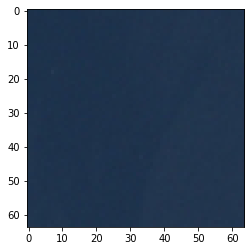

In [8]:
%matplotlib inline

class_to_idx = {
        'AnnualCrop': 0,
        'Forest': 1,
        'HerbaceousVegetation': 2,
        'Highway': 3,
        'Industrial': 4,
        'Pasture': 5,
        'PermanentCrop': 6,
        'Residential': 7,
        'River': 8,
        'SeaLake': 9,
    }
idx_to_class = {v: k for k, v in class_to_idx.items()}

images = [os.path.join('EuroSAT/train', x, x+'_'+str(random.randint(3,10))+'.jpg') for x in class_to_idx.keys()]

for item in images:
  print(os.path.basename(item))
  img = Image.open(item)
  plt.imshow(img)

# Train model

In [9]:
# Params

printFreq = 10
# Hardware
device = torch.device('cuda')
# Batch size
batchSize = 64
# Transfer learning?
usePretrained = True
# Initial learning rate
learningRate = 0.1
# epochs
n_epochs = 50

In [10]:
# Data loaders
train_loader = DataLoader(trainData, batch_size=batchSize, shuffle=True)
val_loader   = DataLoader(valData,   batch_size=batchSize, shuffle=True)

In [11]:
# Load model
torch.backends.cudnn.benchmark = True
model = resnet18(in_channels=3, num_classes=n_classes, pretrained=usePretrained)
model.to(device)

# Define learning components
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learningRate)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [12]:
def train_one_epoch(model, criterion, optimizer, data_loader, device, epoch, print_freq, writer):
    model.train()
    for idx, (image, target) in enumerate(data_loader):
        image, target = image.to(device), target.to(device)
        output = model(image)
        loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if idx % print_freq == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, idx * len(image), len(data_loader.dataset), 100. * idx / len(data_loader), loss.item()))
            # writer.add_scalar('train/loss', loss.item(), len(data_loader) * epoch + idx)

In [13]:
def evaluate(epoch, model, criterion, data_loader, device, writer):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for idx, (image, target) in enumerate(data_loader):
            image = image.to(device, non_blocking=True)
            target = target.to(device, non_blocking=True)
            output = model(image)
            loss += criterion(output, target).item()

            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

        loss /= len(data_loader.dataset)/data_loader.batch_size

        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            loss, correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset)))
        # writer.add_scalar('test/loss', loss, len(data_loader) * epoch)
        # writer.add_scalar('test/accuracy', correct / len(data_loader.dataset), epoch)

In [14]:
writer = SummaryWriter(url_models)
if TRAIN:
  # Train
  for epoch in range(n_epochs):
    # writer.add_scalar('train/learning_rate', lr_scheduler.get_last_lr()[0], epoch)
    train_one_epoch(model, criterion, optimizer, train_loader, device, epoch, printFreq, writer)
    lr_scheduler.step()
    evaluate(epoch, model, criterion, val_loader, device, writer)
    torch.save(model.state_dict(), os.path.join(url_models, "cls_epoch_{}.pth".format(epoch)))

Train Epoch: 0 [0/24300 (0%)]	Loss: 2.549440
Train Epoch: 0 [640/24300 (3%)]	Loss: 2.765374
Train Epoch: 0 [1280/24300 (5%)]	Loss: 2.501912
Train Epoch: 0 [1920/24300 (8%)]	Loss: 2.355376
Train Epoch: 0 [2560/24300 (11%)]	Loss: 2.158963
Train Epoch: 0 [3200/24300 (13%)]	Loss: 2.178371
Train Epoch: 0 [3840/24300 (16%)]	Loss: 2.192205
Train Epoch: 0 [4480/24300 (18%)]	Loss: 2.048005
Train Epoch: 0 [5120/24300 (21%)]	Loss: 1.957199
Train Epoch: 0 [5760/24300 (24%)]	Loss: 1.598687
Train Epoch: 0 [6400/24300 (26%)]	Loss: 1.971971
Train Epoch: 0 [7040/24300 (29%)]	Loss: 1.657825
Train Epoch: 0 [7680/24300 (32%)]	Loss: 1.417235
Train Epoch: 0 [8320/24300 (34%)]	Loss: 1.569386
Train Epoch: 0 [8960/24300 (37%)]	Loss: 1.644666
Train Epoch: 0 [9600/24300 (39%)]	Loss: 1.627006
Train Epoch: 0 [10240/24300 (42%)]	Loss: 1.587335
Train Epoch: 0 [10880/24300 (45%)]	Loss: 1.210019
Train Epoch: 0 [11520/24300 (47%)]	Loss: 1.554707
Train Epoch: 0 [12160/24300 (50%)]	Loss: 1.534478
Train Epoch: 0 [12800/24

In [15]:
# Save model
if TRAIN:
  torch.save(model, path_model)

# Load model
model = torch.load(path_model)
model.eval();

# Evaluate model

In [16]:
def getPredictions(model, data_loader, device, print_freq):
    model.eval()
    trueLabels = []
    predLabels = []
    # model.to(device, non_blocking=True, type=torch.double)
    model = model.to("cpu", dtype=torch.double)
    with torch.no_grad():
        for idx, (image, target) in enumerate(data_loader):
            # image = image.to(device, non_blocking=True)
            image = image.to("cpu", dtype=torch.double)
            # target = target.to(device, non_blocking=True)
            output = model(image)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            trueLabels.append(target)
            predLabels.append(pred)
            if idx % print_freq == 0:
              print("processed: {}".format(idx))
    return trueLabels, predLabels

In [17]:
# Get validation results
trueLabels, predLabels = getPredictions(model, val_loader, device, printFreq)

processed: 0
processed: 10
processed: 20
processed: 30
processed: 40


In [18]:
trueLabels = [item.item() for sublist in trueLabels for item in sublist]
predLabels = [item.item() for sublist in predLabels for item in sublist]

In [19]:
def plot_confusion_matrix(labels, pred_labels):
    
    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = range(10));
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

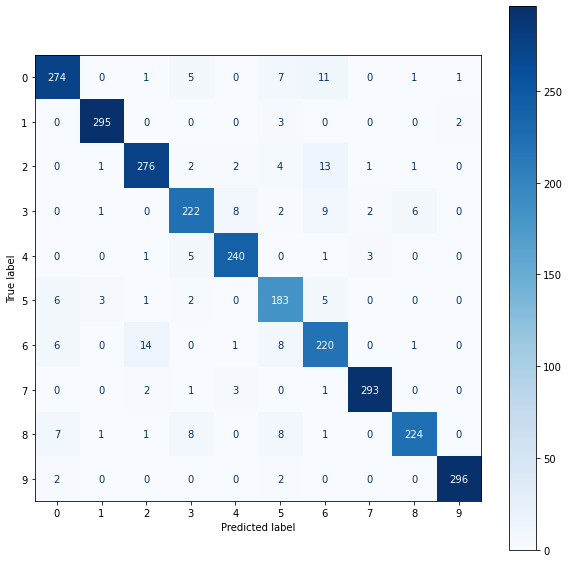

In [20]:
plot_confusion_matrix(trueLabels, predLabels)

In [33]:
def m(X):
  # Go from (batch size, height, width, channels)
  #      to (batch size, channels, height, width)
  X = np.moveaxis(X, (0, 1, 2, 3), (0, 2, 3, 1))

  # Numpy to pytorch tensor
  # image = val_transform(X)
  image = torch.from_numpy(X)  #.ToTensor()

  # Prepare input, model for evaluation
  image = image.to("cpu", dtype=torch.double)
  
  # Evaluate model
  res = model(image)
  return res.detach().numpy()

In [34]:
# Get batch of images, labels
batch = next(iter(val_loader))
X = batch[0]
y = batch[1]

# Convert from tensor (from pytorch) to generic numpy (for shap)
Xshap = X.numpy()
# Go from (batch size, channels, height, width)
#      to (batch size, height, width, channels)
Xshap = np.moveaxis(Xshap, (0, 1, 2, 3), (0, 3, 1, 2))

In [ ]:
# Initial masker and PartitionShap
masker = shap.maskers.Image("blur(20, 20)", Xshap[0].shape)
explainer = shap.Explainer(m, masker, output_names=classes)

# Explain batch (calculate shap values)
shap_values = explainer(Xshap, max_evals=500, batch_size=batchSize, outputs=shap.Explanation.argsort.flip)

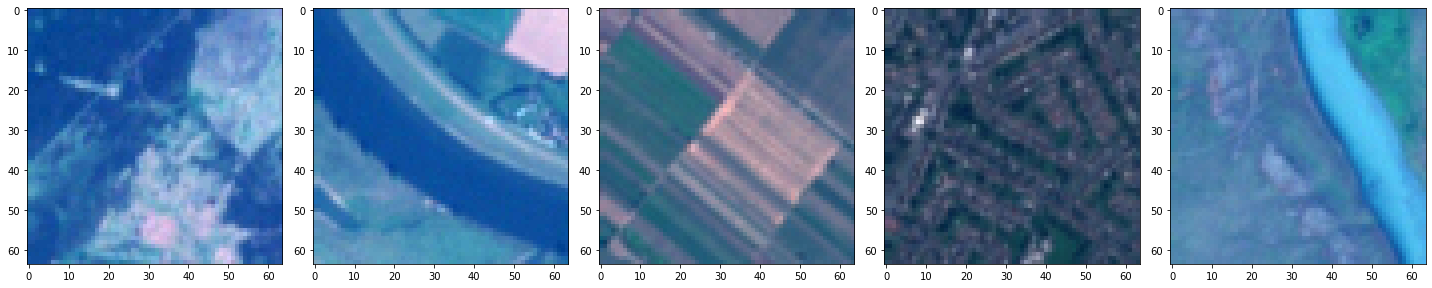

In [79]:
# Accessing images from dataset
fig, axs = plt.subplots(1, 5, figsize=(20,4));
# Train sample
a = Xshap[0]
b = (a - np.min(a))/np.ptp(a)
axs[0].imshow(b);
a = Xshap[1]
b = (a - np.min(a))/np.ptp(a)
axs[1].imshow(b);
a = Xshap[2]
b = (a - np.min(a))/np.ptp(a)
axs[2].imshow(b);
a = Xshap[3]
b = (a - np.min(a))/np.ptp(a)
axs[3].imshow(b);
a = Xshap[4]
b = (a - np.min(a))/np.ptp(a)
axs[4].imshow(b);
plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


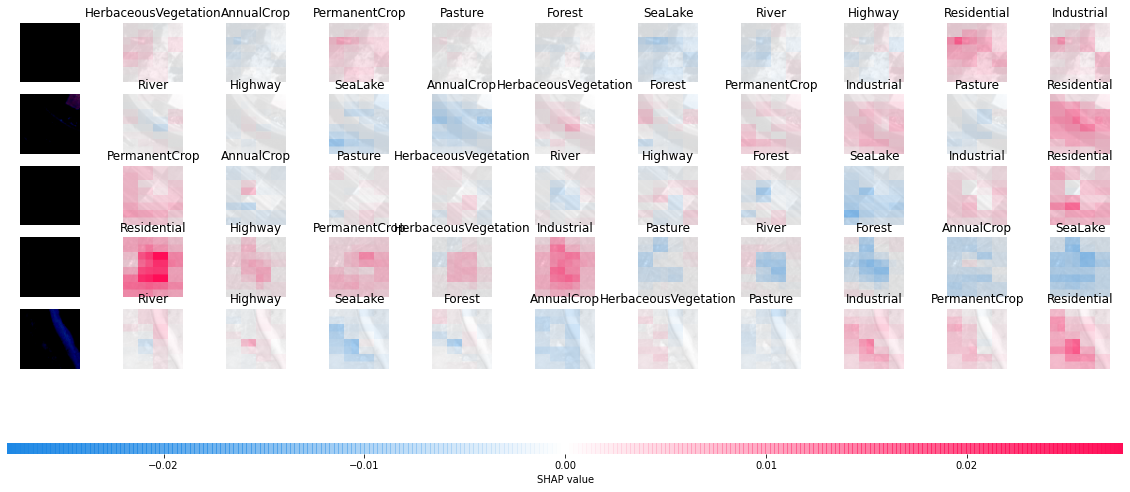

In [80]:
shap.image_plot(shap_values[:5])